In [24]:
#!/usr/bin/env python3
import sys
import matplotlib.pyplot as plt
import os
import splot
import math
import random 
import re
import pickle

import numpy as np
import seaborn as sns
import pandas as pd
import geopandas as gpd
import networkx as nx
import libpysal as lp

from libpysal.weights.contiguity import Queen
from esda.moran import Moran
from esda.moran import Moran_BV
from esda.moran import Moran_Local
from splot.esda import plot_local_autocorrelation
from splot.esda import moran_scatterplot
from splot.esda import plot_moran
from splot.esda import plot_moran_bv
from sklearn.cluster import DBSCAN
from scipy.spatial import Voronoi, voronoi_plot_2d

import shapely.geometry
import shapely.ops
from shapely.geometry import Polygon
from shapely.geometry import LineString
from shapely.geometry import Point

import fanc as fanc
#import fanc.plotting as fancplot
import pyBigWig
from scipy.sparse import csr_matrix
from shapely.geometry import Point
from scipy.spatial import distance

import warnings
warnings.filterwarnings('ignore')

# Functions

In [65]:
def GetPointId(cs,p):
    i = 0
    for c in cs:
        if (p.contains(Point(c))):
            return(i)
            continue
        else:
            i=i+1

def GetPointIds(cs,p):
    i = 0
    ids = []
    for c in cs:
        #print(point,Point(c),p.contains(Point(c)))
        if (p.contains(Point(c))):
            ids.append(i)
            i=i+1
        else:
            i=i+1
    return(np.unique(ids))

def signalProfile(bw,reg,res,pc,norm):    
    sig = []
    c,i,e = re.split(':|-',reg)
    i = int(i)
    e = int(e)+1
    for coor in range(i,e,res):
        try:
            asum = sum(bw.values('chr'+c, coor, coor+res))
            if (asum < pc):
                #asum = 0
                #asum = np.NaN
                asum = pc
        except RuntimeError:
            asum = pc
            #asum = np.NaN
        sig.append(asum)
    if (isinstance(norm, (int, float))):
        sig = [float(i)/norm for i in sig]
    if (norm == 'max'):
        sig = [float(i)/max(sig) for i in sig]
    if (norm == 'sum'):
        sig = [float(i)/sum(sig) for i in sig]
    return(sig)

def MLs(gene,region,gender,dataset,cf,reso,midp,sigdata,hicfile,sigfile):
    
    # Variables to set for function
    plotsize  = 10 # Size of plots
    logcutoff = 1. # Min cut-off for log10(Hi-C interactions)
    minsig    = 1. # Min signal data per bin (pseudo-counts)
    influence = 1.5 # Influence of consecutive particles
    bfact     = 2 # Buffer space for Voronoi
    mli_per   = 50000 # Permutations to assess MLI p-value
    
    # Collect HiC
    hic = fanc.load(hicfile)
    print("Bin size {}: {:,}bp for region {}".format(hicfile,hic.bin_size,region))

    # Get matrix
    print("Input Hi-C matrix at {} resolution.".format(reso))
    ma = hic.matrix(region)[region,region]
    cm = np.log10(ma*cf) # In case coverage needs to be corrected use cf variable
    fig, ax = plt.subplots(figsize=(plotsize, plotsize))
    ax.imshow(cm.data)
    plt.savefig('Sox9_Example/{}_{}_{}_hic.pdf'.format(gene,gender,dataset))
    plt.show()
    plt.close()

    # Get only the significant pairs
    subm = cm.data.copy()
    subm = np.where(subm==1., 0, subm) 
    subm[subm < logcutoff] = 0

    # Connectivity
    rng = np.arange(len(subm)-1)
    subm[rng, rng+1] = 1.

    # Remove exact diagonal
    subm[rng, rng] = 0

    # Plot
    fig, ax = plt.subplots(figsize=(plotsize, plotsize))
    ax.imshow(subm)
    plt.savefig('Sox9_Example/{}_{}_{}_subhic.pdf'.format(gene,gender,dataset))
    plt.close()

    # Modify the matrix and transorm to restraints
    subm = np.where(subm==0, np.nan, subm) # Remove zeroes
    subm = np.where(subm==1, 10, subm) # Increase connectivity 
    subm = 1/subm # Convert to distance Matrix instead of similarity matrix
    subm = np.triu(subm, k=0) # Remove lower diagonal
    subm[subm == np.inf] = 0 # Clean inf 
    subm = np.nan_to_num(subm) # Clean nans
    
    # Plot
    fig, ax = plt.subplots(figsize=(plotsize, plotsize))
    ax.imshow(subm)
    plt.savefig('Sox9_Example/{}_{}_{}_restraints.pdf'.format(gene,gender,dataset))
    plt.close()

    # Create sparse matrix
    matrix = csr_matrix(subm)
    print("Sparse matrix contains {:,} restraints".format(np.count_nonzero(matrix.toarray())))

    # Get the KK layout
    print("Layouting KK...")
    G = nx.from_scipy_sparse_matrix(matrix)
    pos = nx.kamada_kawai_layout(G)
    
    # Get distance matrix
    coords = list(pos.values())
    dists = distance.cdist(coords, coords, 'euclidean')

    # Save coordinates
    cfile = 'Sox9_Example/{}_{}_{}.pkl'.format(gene,gender,dataset)
    with open(cfile, 'wb') as output:
        pickle.dump(matrix, output)    
        pickle.dump(pos, output)
        pickle.dump(dists, output)
        pickle.dump(coords, output)    
        pickle.dump(G, output)    

    # Close HiC
    print("closing hic")
    hic.close()

    # See the Kamada-Kawai layout
    print("Plotting KK...")
    color_map = []
    plt.figure(figsize=(plotsize,plotsize)) 
    options = {
        'node_size': 50,
        'edge_color': 'silver',
        'linewidths': 0.1,
        'width': 0.05, 
    }
    nx.draw(G, pos, node_color=range(len(pos)), cmap=plt.cm.coolwarm, **options)
    plt.scatter(pos[midp][0],pos[midp][1], s=80, facecolors='none', edgecolors='r')
    xs = [pos[n][0] for n in pos]
    ys = [pos[n][1] for n in pos]
    sns.lineplot(x = xs, y = ys, sort=False, lw=2, color='black', legend = False, zorder=1)
    plt.savefig('Sox9_Example/{}_{}_{}_kk.pdf'.format(gene,gender,dataset))
    plt.show()
    plt.close()

    # Collect signal data
    print("Getting signal data for {}...".format(sigdata))
    bwdata = pyBigWig.open(sigfile)
    signal = signalProfile(bwdata,region,reso,minsig,'max')
    signal = np.log10(signal)
    print('Signal stats:',np.min(signal),np.max(signal),len(signal))

    # See the map with signal colors
    print("Mapping into Kamada-Kawai signal data...")
    color_map = []
    plt.figure(figsize=(plotsize,plotsize)) 
    nx.draw(G, pos, node_color=signal[0:len(pos)], cmap=plt.cm.coolwarm, **options)
    plt.scatter(pos[midp][0],pos[midp][1], s=80, facecolors='none', edgecolors='r')
    xs = [pos[n][0] for n in pos]
    ys = [pos[n][1] for n in pos]
    sns.lineplot(x = xs, y = ys, sort=False, lw=2, color='black', legend = False, zorder=1)
    plt.savefig('Sox9_Example/{}_{}_{}_kk_{}.pdf'.format(gene,gender,dataset,sigdata))
    plt.show()
    plt.close()

    # From points to Voronoi polygons
    print("Voronoing KK...")
    points = coords
    
    # set limits
    lims = 2
    points = coords.copy()
    points.append(np.array([-lims,lims]))
    points.append(np.array([lims,-lims]))
    points.append(np.array([lims,lims]))
    points.append(np.array([-lims,-lims]))
    points.append(np.array([-lims,0]))
    points.append(np.array([0,-lims]))
    points.append(np.array([lims,0]))
    points.append(np.array([0,lims]))
    
    # Get Voronoi volumes from Kamada-Kawai layout
    print("Calculating Voronoi Polygons...")
    vor = Voronoi(points)
    
    # Get polygons
    print("Voronoi Polygons and mapped data...")
    lines = [
        shapely.geometry.LineString(vor.vertices[line])
        for line in vor.ridge_vertices
        if -1 not in line
    ]
    mydata = gpd.GeoDataFrame(columns=['v','geometry'])
    for poly in shapely.ops.polygonize(lines):
        coordid =  GetPointId(coords,poly)
        v = signal[coordid]
        mydata = mydata.append({'v':v,'geometry':poly}, ignore_index=True)
    print("Voronois polygons for {} points...".format(len(mydata)))
    
    # Get average distance between consequitive points to define influence
    mdist = dists.diagonal(1).mean()
    buffer = mdist*influence
    print("Average distance between consecutive particles {:6.4f} [{:6.4f}]".format(mdist,buffer))

    # Voronoi shaped & closed
    shape = LineString(coords).buffer(buffer)
    close = mydata.convex_hull.union(mydata.buffer(0.1, resolution=1)).geometry.unary_union
    i = 0
    for q in mydata.geometry:
        mydata.geometry[i] = q.intersection(close)
        mydata.geometry[i] = shape.intersection(q)
        i = i+1
        
    # Get weights for geometric distance
    print("Getting weights and geometric distance for LM")
    y = mydata['v'].values
    w = lp.weights.DistanceBand.from_dataframe(mydata, buffer*bfact)
    while (len(w.islands)): # In case of "islands" increase buffer until no islands
        bfact = bfact+0.1
        w = lp.weights.DistanceBand.from_dataframe(mydata, buffer*bfact)
        print("\tIncreased buffer to {}... there are islands...".format(bfact))
    w.transform = 'r'
    
    # Get Global Moran Index
    moran = Moran(y, w)
    if (math.isnan(moran.I)):
        print(">>> ERROR... MATH NAN")
        return()
    print("Global Moran Index: {:4.2f} with p-val: {:6.4f} ".format(moran.I,moran.p_sim))
    
    # Show Global Moran Plot
    plot_moran(moran, zstandard=False, figsize=(10,4))
    plt.savefig('Sox9_Example/{}_{}_{}_gmoran.pdf'.format(gene,gender,dataset))
    plt.show()
    plt.close()  
    
    # calculate Moran_Local and plot
    signipval = 0.05
    moran_loc = Moran_Local(y, w, permutations=mli_per)
    print("There are a total of {} significant points in Local Moran Index".format(len(moran_loc.p_sim[(moran_loc.p_sim<signipval) & (moran_loc.q == 1)])))

    # Plot results
    print("Final LMI plot...")
    plot_local_autocorrelation(moran_loc, mydata, 'v', p=signipval, cmap="coolwarm", scheme='EqualInterval')
    plt.savefig('Sox9_Example/{}_{}_{}_lmoran.pdf'.format(gene,gender,dataset))
    plt.show()
    plt.close()
    
    # Get ids for all sites in the LMI map
    print("Getting ids for all sites in the LMI map: {:,}".format(len(mydata)))
    pids = []
    for p in mydata.geometry:
        pids.append(GetPointId(coords,p))
    midploc = [i for i,x in enumerate(pids) if x == midp][0]
    midp_pv = moran_loc.p_sim[midploc]
    midp_ty = moran_loc.q[midploc]
    midp_Is = moran_loc.Is[midploc]

    # Get ids of significant High-High
    # HH=1, LH=2, LL=3, HL=4
    print("Subsetting significant HH and LH geometries...")
    mask = (moran_loc.p_sim<=signipval) & (moran_loc.q<=2)
    HHdata = mydata[mask]

    # Which points are HH?
    hhpoints = []
    for index, ld in HHdata.iterrows():
        hhpoints.append(GetPointId(coords,ld.geometry))
    hhpoints = list(set(hhpoints))

    # Find blocks ids in each metaloci and get bed file
    bedfile = 'Sox9_Example/{}_{}_{}.bed'.format(gene,gender,dataset)
    beddata = pd.DataFrame(columns=['chr','start','end','pid'])
    print("Mapping METALoci ...")
    metaloci_data = pd.DataFrame()
    if (HHdata.unary_union.geom_type == 'MultiPolygon'):
        for i in range(0,len(HHdata.unary_union)):
            ml = HHdata.unary_union[i]
            ids = GetPointIds(coords,ml)
            if (midp in ids):
                continue
    else:
        ml = HHdata.unary_union
    ids = GetPointIds(coords,ml)
    
    # Collect all info per bin in KK
    ldbd = pd.DataFrame(columns=['Region','KKindex','KKx','KKy',
                                 'Signal','LMpval','LMq','LMI','geometry'])
    ldbfile = 'Sox9_Example/{}_{}_{}_{}_{}.tsv'.format(gene,gender,dataset,reso,sigdata)
    print("Saving data {:,} entries...".format(len(mydata)))
    for index, row in mydata.iterrows():
        pid = GetPointId(coords,row.geometry)
        itype = 'ns'
        new_row = {'Region':region,
                   'KKindex':pid+1,
                   'KKx':coords[pid][0],
                   'KKy':coords[pid][1],
                   'Signal':signal[pid],
                   'LMpval':moran_loc.p_sim[index],
                   'LMq':moran_loc.q[index],
                   'LMI':moran_loc.Is[index],
                   'geometry':row.geometry}
        ldbd = ldbd.append(new_row, ignore_index=True)

    # Reindex, resort and save
    ldbd.index = pids
    ldbd = ldbd.sort_index()
    ldbd.to_csv(ldbfile, sep='\t', index=False)
    hhmidp = midp in hhpoints
    if (hhmidp):
        print(">>> YES-ML {} [{}] {} [{} {} {}]".format(gene,midp,dataset,midp_ty,midp_pv,midp_Is))
    else:
        print(">>> NOT-ML {} [{}] {} [{} {} {}]".format(gene,midp,dataset,midp_ty,midp_pv,midp_Is))

In [68]:
# INITIAL VARIABLES
reso    = 10000 # Resolution of the Hi-C maps
gene    = 'Sox9' # Gene of interest
gender  = 'Male' # Sample 
dataset = '13.5' # Time point
sigdata = 'H3K27ac' # Signal
region  = '11:110780000-114760000' # Region of interest
midp    = 199 # Middle particle in KK layoput (TSS bin)
hicfile = 'Sox9_Example/input/13.5_chr11_110780000_114770000.fanc' # Hi-C input data in FANC format
sigfile = 'Sox9_Example/input/13.5_H3K27ac_chr11_110780000_114770000.bw' # Signal data (H3K27ac) on bigWig format

Running Sox9 on 13.5 dataset
Bin size Sox9_Example/input/13.5_chr11_110780000_114770000.fanc: 10,000bp for region 11:110780000-114760000
Input Hi-C matrix at 10000 resolution.


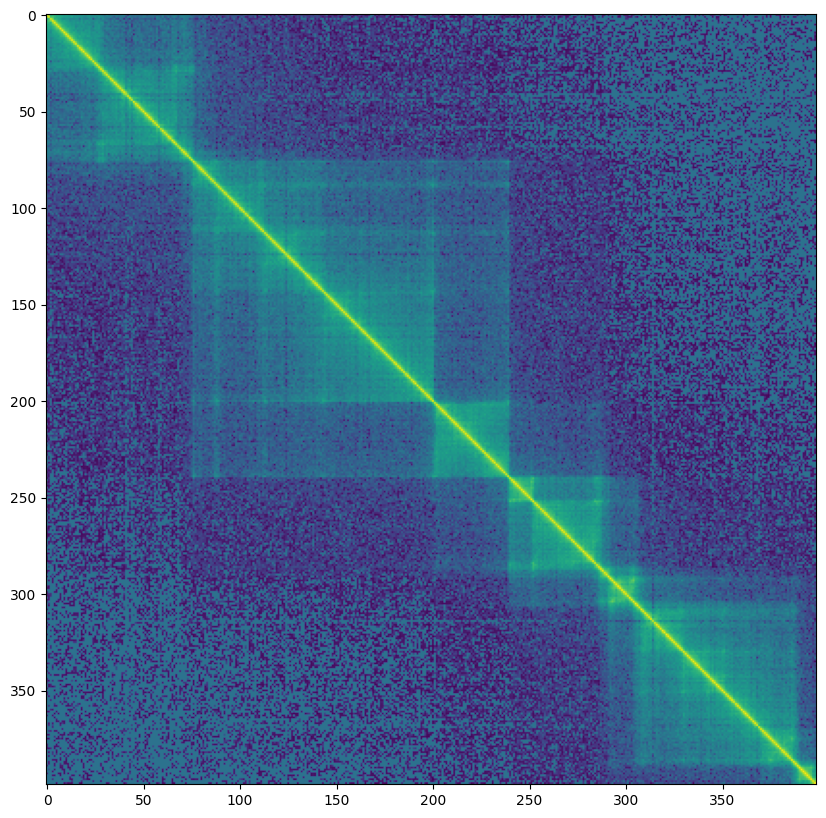

Sparse matrix contains 14,523 restraints
Layouting KK...
closing hic
Plotting KK...


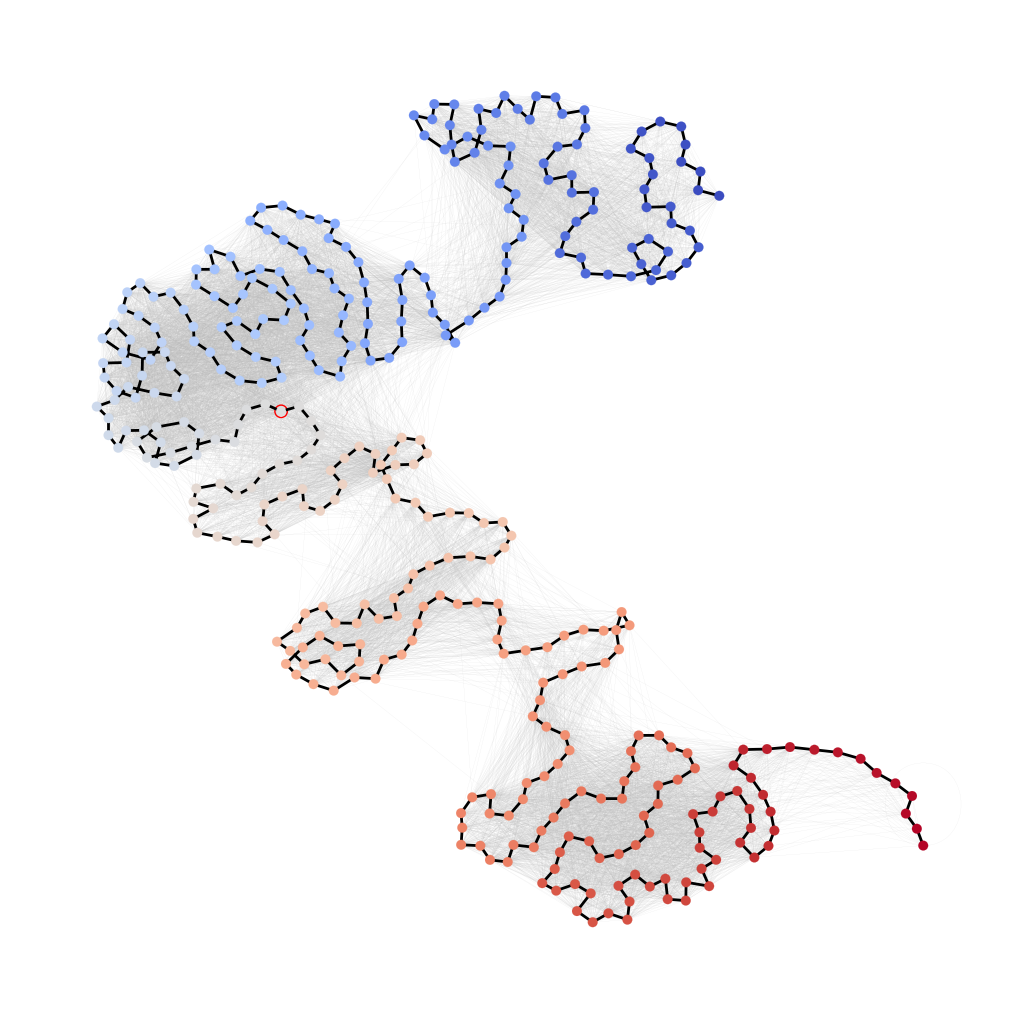

Getting signal data for H3K27ac...
Signal stats: -3.7506204405055246 0.0 399
Mapping into Kamada-Kawai signal data...


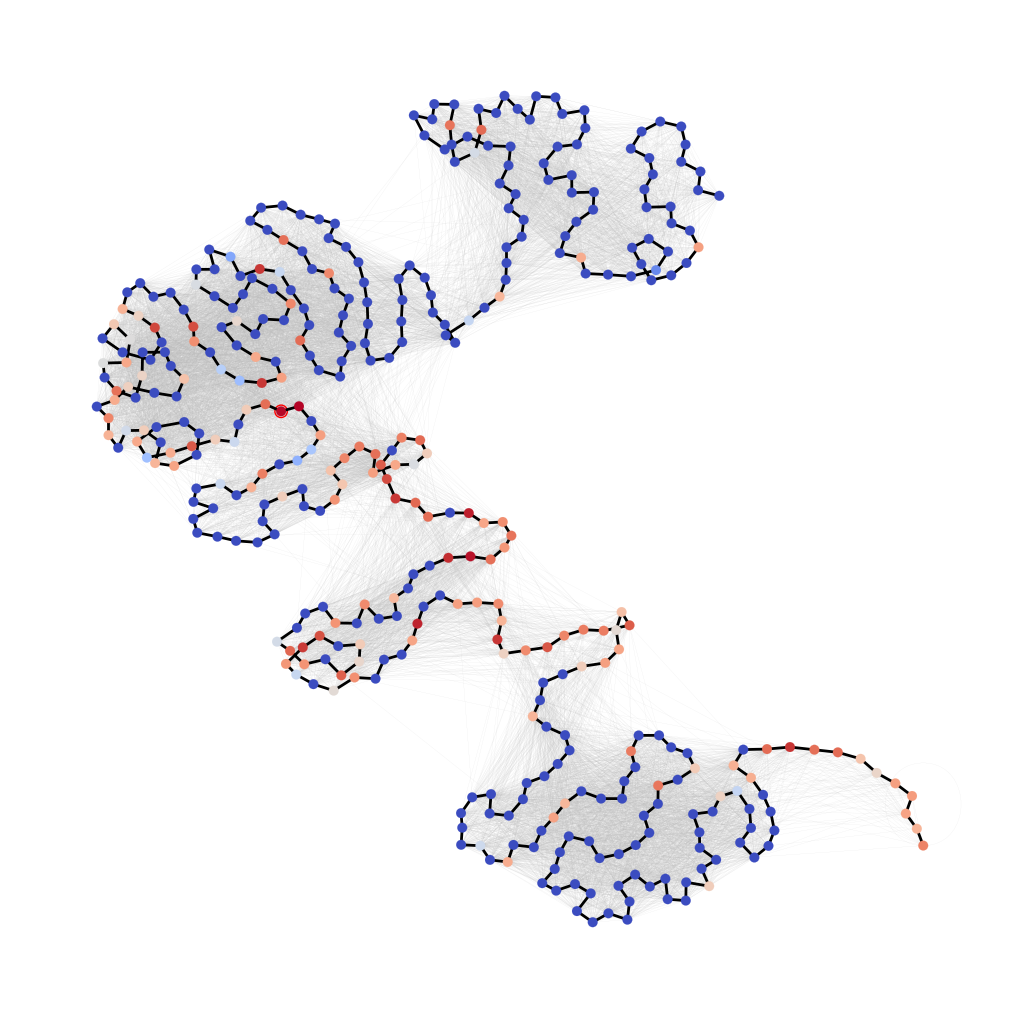

Voronoing KK...
Calculating Voronoi Polygons...
Voronoi Polygons and mapped data...
Voronois polygons for 399 points...
Average distance between consecutive particles 0.0400 [0.0600]
Getting weights and geometric distance for LM
Global Moran Index: 0.37 with p-val: 0.0010 


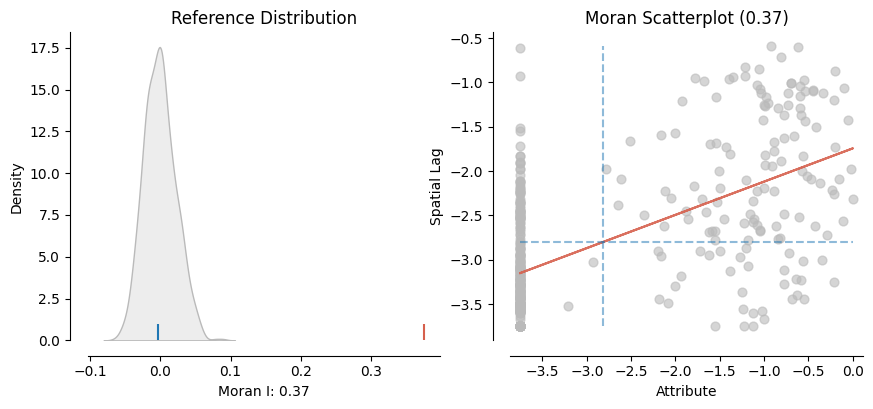

There are a total of 75 significant points in Local Moran Index
Final LMI plot...


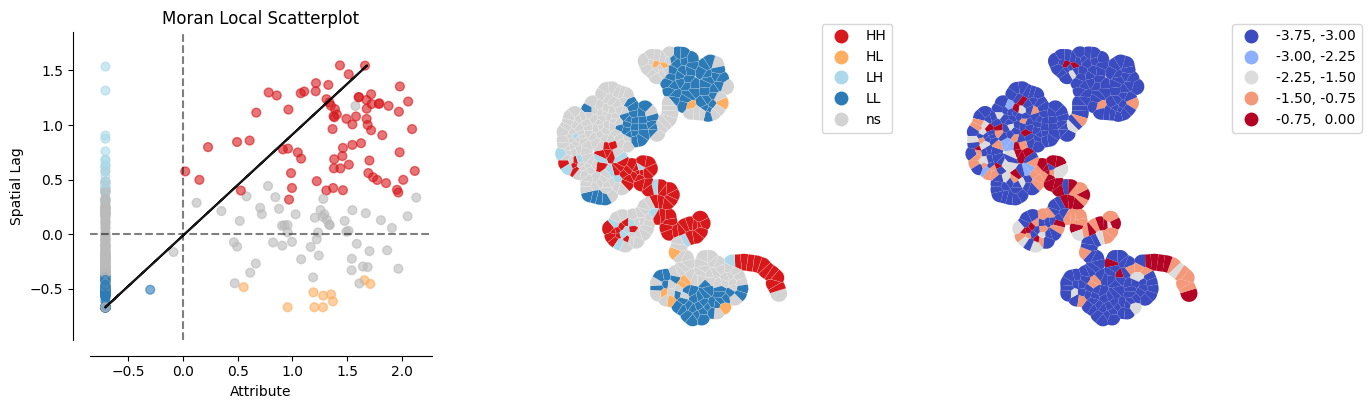

Getting ids for all sites in the LMI map: 399
Subsetting significant HH and LH geometries...
Mapping METALoci ...
Saving data 399 entries...
>>> YES-ML Sox9 [199] 13.5 [1 0.011699766004679906 1.3518494324493093]


In [69]:
# Run METALoci
chrm,cini,cend =re.split(':|-',region)
print("Running {} on {} dataset".format(gene,dataset))
MLs(gene,region,gender,dataset,1.0,reso,midp,sigdata,hicfile,sigfile)